In [6]:
# S3 bucket and prefix
bucket = 'solutionudacity20250625'
prefix = 'sagemaker/DEMO-data-distribution-types'

# Define IAM role
from sagemaker import get_execution_role

role = get_execution_role()

In [ ]:
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import io
import time
import copy
import sagemaker.amazon.common as smac
import os

In [ ]:
def get_gdelt(filename):
    df = pd.read_csv(filename, sep=',', low_memory=False)
    return df

data = get_gdelt('gdelt_1979.csv')
data

,GLOBALEVENTID,SQLDATE,MonthYear,Year,FractionDate,Actor1Code,Actor1Name,Actor1CountryCode,Actor1KnownGroupCode,Actor1EthnicCode,...,Actor2Geo_FeatureID,ActionGeo_Type,ActionGeo_FullName,ActionGeo_CountryCode,ActionGeo_ADM1Code,ActionGeo_Lat,ActionGeo_Long,ActionGeo_FeatureID,DATEADDED,SOURCEURL
0,190920,19790626,197906,1979,1979.4822,NaN,NaN,NaN,NaN,NaN,...,0,1.0,NaN,RB,RB,0.0000,0.0000,0.0,20130203,unspecified
1,65410,19790306,197903,1979,1979.1808,NaN,NaN,NaN,NaN,NaN,...,0,1.0,Laos,LA,LA,18.0000,105.0000,0.0,20130203,unspecified
2,230365794,19790212,197902,1979,1979.1151,NaN,NaN,NaN,NaN,NaN,...,0,1.0,Ghana,GH,GH,8.0000,-2.0000,0.0,20130206,unspecified
3,144299,19790518,197905,1979,1979.3781,NaN,NaN,NaN,NaN,NaN,...,0,1.0,India,IN,IN,20.0000,77.0000,0.0,20130203,unspecified
4,372325,19791208,197912,1979,1979.9260,NaN,NaN,NaN,NaN,NaN,...,0,1.0,Italy,IT,IT,42.8333,12.8333,0.0,20130203,unspecified
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430936,198829,19790702,197907,1979,1979.4986,UAF,TERRORIST,NaN,NaN,NaN,...,-2312291,4.0,"Salisbury, Mashonaland East, Zimbabwe",ZI,ZI04,-17.8178,31.0447,-2312291.0,20130203,unspecified
430937,151321,19790523,197905,1979,1979.3918,ZWEELI,ROBERT MUGABE,ZWE,NaN,NaN,...,-2312291,4.0,"Salisbury, Mashonaland East, Zimbabwe",ZI,ZI04,-17.8178,31.0447,-2312291.0,20130203,unspecified
430938,390337,19791227,197912,1979,1979.9781,AFRBUS,AFRICA,AFR,NaN,NaN,...,-2312291,4.0,"Salisbury, Mashonaland East, Zimbabwe",ZI,ZI04,-17.8178,31.0447,-2312291.0,20130203,unspecified
430939,311112,19791015,197910,1979,1979.7808,AFRCVL,AFRICA,AFR,NaN,NaN,...,-2312291,4.0,"Salisbury, Mashonaland East, Zimbabwe",ZI,ZI04,-17.8178,31.0447,-2312291.0,20130203,unspecified


col_0,% observations
EventCode,
10,0.060275
11,0.001703
12,0.013786
13,0.014074
14,0.006790
...,...
1821,0.000223
1822,0.000601
1823,0.000079


,NumArticles,AvgTone,Actor1Geo_Lat,Actor1Geo_Long,Actor2Geo_Lat,Actor2Geo_Long
count,430941.000000,430941.000000,430941.000000,430941.000000,430941.000000,430941.000000
mean,4.369705,5.127216,26.332138,26.089644,23.126694,23.619146
std,3.121314,2.637795,21.884745,61.133487,22.155755,57.699878
min,1.000000,0.000000,-85.622100,-179.050000,-85.622100,-179.050000
25%,2.000000,3.333333,10.000000,0.000000,0.000000,0.000000
50%,4.000000,5.000000,32.000000,28.229400,30.044500,19.500000
75%,6.000000,6.666667,40.400000,53.000000,39.928900,50.093800
max,54.000000,28.571429,85.000000,180.000000,85.000000,180.000000


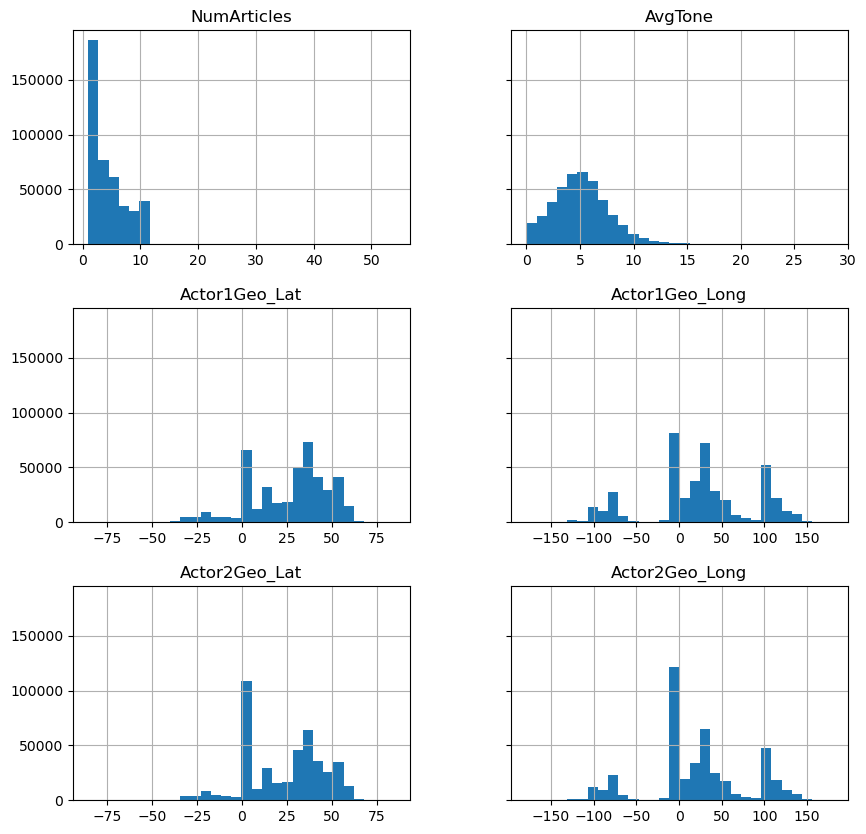

In [10]:
data = data[['EventCode', 'NumArticles', 'AvgTone', 'Actor1Geo_Lat', 'Actor1Geo_Long', 'Actor2Geo_Lat', 'Actor2Geo_Long']].copy()
data['EventCode'] = data['EventCode'].astype(object)

for column in data.select_dtypes(include=['object']).columns:
    display(pd.crosstab(index=data[column], columns='% observations', normalize='columns'))

display(data.describe())
hist = data.hist(bins=30, sharey=True, figsize=(10, 10))
plt.show()

In [11]:
events = pd.crosstab(index=data['EventCode'], columns='count').sort_values(by='count', ascending=False).index[:20]

Perform the same process for other years of data.

In [12]:
def write_to_s3(bucket, prefix, channel, file_prefix, X, y):
    buf = io.BytesIO()
    smac.write_numpy_to_dense_tensor(buf, X.astype('float32'), y.astype('float32'))
    buf.seek(0)
    boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, channel, file_prefix + '.data')).upload_fileobj(buf)


def transform_gdelt(df, events=None):
    df = df[['AvgTone', 'EventCode', 'NumArticles', 'Actor1Geo_Lat', 'Actor1Geo_Long', 'Actor2Geo_Lat', 'Actor2Geo_Long']].copy()
    df['EventCode'] = df['EventCode'].astype(object)
    if events is not None:
        df = df[np.in1d(df['EventCode'], events)]
    return pd.get_dummies(df[((df['Actor1Geo_Lat'] == 0) & (df['Actor1Geo_Long'] == 0) != True) & 
        ((df['Actor2Geo_Lat'] == 0) & (df['Actor2Geo_Long'] == 0) != True)])


def prepare_gdelt(bucket, prefix, file_prefix, events=None, random_state=1729):
    df = get_gdelt(f'gdelt_{file_prefix}.csv')
    model_data = transform_gdelt(df, events)
    train_data, validation_data = np.split(model_data.sample(frac=1, random_state=random_state).values, 
                                           [int(0.9 * len(model_data))])

    write_to_s3(bucket, prefix, 'train', file_prefix, train_data[:, 1:], train_data[:, 0])
    write_to_s3(bucket, prefix, 'validation', file_prefix, validation_data[:, 1:], validation_data[:, 0])

for year in range(1979, 1984):
    prepare_gdelt(bucket, prefix, str(year), events)

In [13]:
containers = {'us-west-2': '174872318107.dkr.ecr.us-west-2.amazonaws.com/linear-learner:latest',
              'us-east-1': '382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner:latest',
              'us-east-2': '404615174143.dkr.ecr.us-east-2.amazonaws.com/linear-learner:latest',
              'eu-west-1': '438346466558.dkr.ecr.eu-west-1.amazonaws.com/linear-learner:latest'}
container = containers[boto3.Session().region_name]

In [ ]:
common_training_params = {
    "RoleArn": role,
    "AlgorithmSpecification": {
        "TrainingImage": container,
        "TrainingInputMode": "File"
    },
    "ResourceConfig": {
        "InstanceCount": 1,
        "InstanceType": "ml.c4.2xlarge",#,#"ml.t3.medium",#"ml.c5.xlarge",#"ml.m4.xlarge",
        "VolumeSizeInGB": 10
    },
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": "s3://{}/{}/train/".format(bucket, prefix)
                }
            },
            "CompressionType": "None",
            "RecordWrapperType": "None"
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": "s3://{}/{}/validation/".format(bucket, prefix),
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "CompressionType": "None",
            "RecordWrapperType": "None"
        }

    ],
    "OutputDataConfig": {
        "S3OutputPath": "s3://{}/{}/".format(bucket, prefix)
    },
    "HyperParameters": {
        "feature_dim": "25",
        "mini_batch_size": "500",
        "predictor_type": "regressor",
        "epochs": "2",
        "num_models": "32",
        "loss": "absolute_loss"
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 60 * 60
    }
}

In [17]:
sharded_job = 'DEMO-linear-sharded-' + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

print("Job name is:", sharded_job)

sharded_training_params = copy.deepcopy(common_training_params)
sharded_training_params['TrainingJobName'] = sharded_job
sharded_training_params['InputDataConfig'][0]['DataSource']['S3DataSource']['S3DataDistributionType'] = 'ShardedByS3Key'

Job name is: DEMO-linear-sharded-2025-06-25-14-01-05


In [18]:
replicated_job = 'DEMO-linear-replicated-' + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

print("Job name is:", replicated_job)

replicated_training_params = copy.deepcopy(common_training_params)
replicated_training_params['TrainingJobName'] = replicated_job
replicated_training_params['InputDataConfig'][0]['DataSource']['S3DataSource']['S3DataDistributionType'] = 'FullyReplicated'

Job name is: DEMO-linear-replicated-2025-06-25-14-01-16


In [ ]:
%%time

region = boto3.Session().region_name
sm = boto3.Session().client('sagemaker')

job_name = sharded_training_params['TrainingJobName']

sm.create_training_job(**sharded_training_params)

# sm.create_training_job(**replicated_training_params)

status = sm.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
print(status)

sm.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=job_name)

status = sm.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
print("Training job ended with status: " + status)

if status == 'Failed':
    message = sm.describe_training_job(TrainingJobName=job_name)['FailureReason']
    print('Training failed with the following error: {}'.format(message))
    raise Exception('Training job failed')

timing1
17918.350216717
InProgress
Training job ended with status: Completed
timing
360.91712474999804
